In [2]:
import pathlib

import yaml

import numpy as np

import itertools

In [12]:
from pixell import enmap, utils as putils

In [3]:
import utilities as u

In [4]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [63]:
paperplots = pathlib.Path('paperplots')

### Some general settings

In [6]:
values_file = 'config.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [173]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [15]:
C = u.Converting()

In [16]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [17]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [18]:
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

In [19]:
PP

PosixPath('output')

## Plot noises for lmax = 3500 vs signal

In [79]:
lmax_fixed = 3500

In [20]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft)

In [22]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['A1', 'A2']
feed_dict = u.Loadfeed_dict(spectra_path, field_names_A, field_names_A, modlmap)

/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:353: RuntimeWarning: divide by zero encountered in log
  logTT = np.log(ctt)


In [23]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 20, 6000

In [44]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [126]:
lmaxes = lmaxes_configs[0] 
lmaxes_dict = {}
lmax_directory = ''

noise_dict = {}

for e_index, e in enumerate(estimators):
    l = lmax_fixed #lmaxes[e_index]
    lmaxes_dict[e] = l
    lmax_directory += f'{names[e]}{l}'
    hardening = estimators_dictionary[e]['hardening']
    A = u.Estimator(shape, wcs, feed_dict, e, lmin_A, lmax_A,
            field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
            hardening = hardening, XY = 'TT')
    NAB_cross = A.get_Nl_cross(A)
    el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    noise_dict[e] = NAB_cross_binned

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul


In [127]:
P = PP/lmax_directory

getoutname = lambda key: f'{key}_{nu}.npy'

noises = np.load(P/getoutname(noisetag))
ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

In [128]:
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 15)

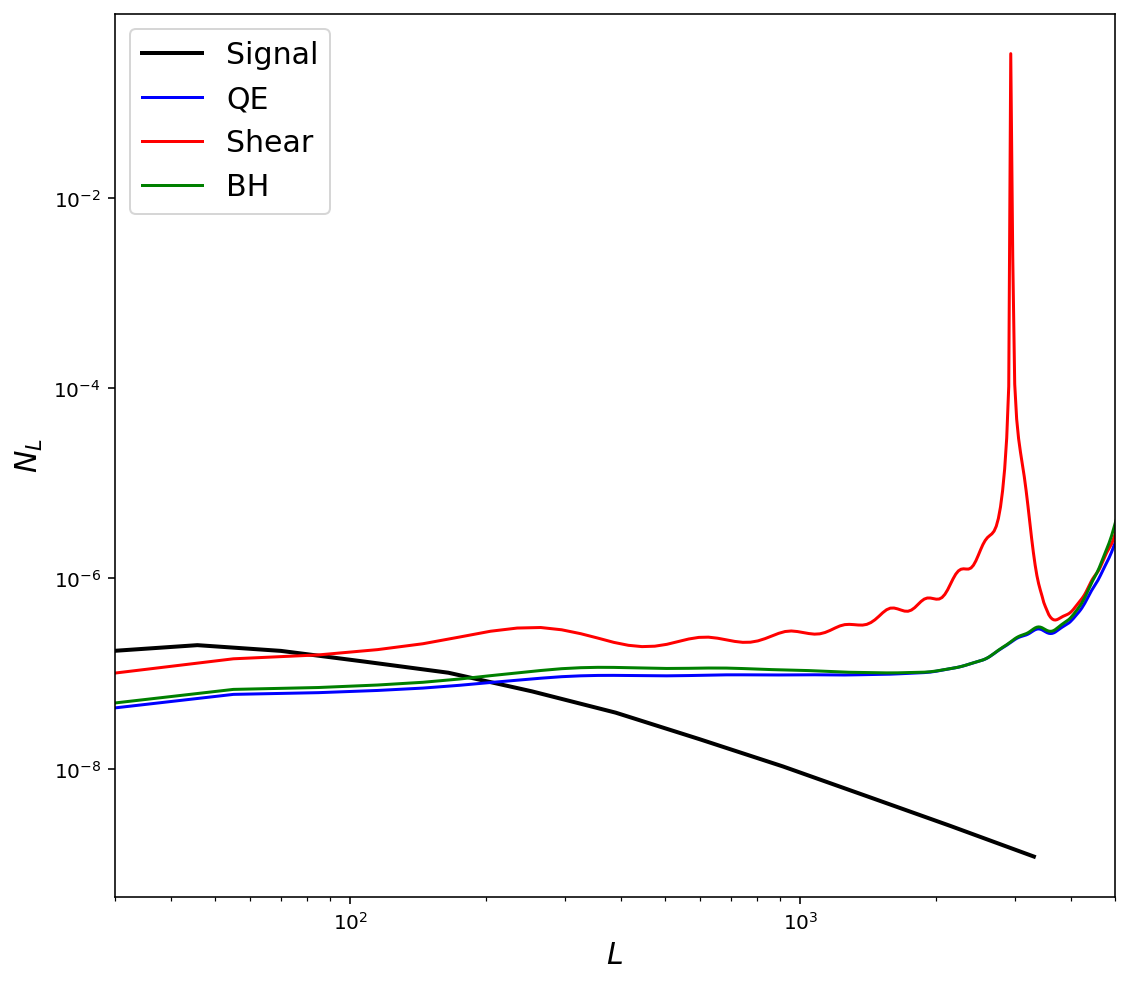

In [129]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)

ax.legend(prop = font)

fig.tight_layout()

fig.savefig(paperplots/'noises_3500.png', dpi = 300)
plt.show()

In [137]:
#ax[0].set_title(f'Best {names[i]}, h{h}_s{s}_b{b}', **csfont)
#fig.tight_layout()

## Foregrounds biases

### Auto

In [195]:
fgnamefiles = ['tsz', 'cib', 'radiops', 'ksz']

In [196]:
foreground = {}
foreground['tsz'] = 'tSZ'
foreground['cib'] = 'CIB'
foreground['ksz'] = 'kSZ'
foreground['radiops'] = 'Radio'

In [197]:
tri = 'Trispectrum'
pri = 'Primary'
pricross = 'Primary Cross'
sec = 'Secondary'
titles = [tri, pri, sec, pricross]

titles_tags = {}
titles_tags[tri] = trispectrumtag
titles_tags[pri] = primarytag
titles_tags[pricross] = primarycrosstag
titles_tags[sec] = secondarytag

In [198]:
ylims = {}

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.01
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.025

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylims[tri] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.1
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.1

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylims[pri] = ylim

#######

ylim = {}

ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.01
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.01
ylim['radiops']['ymax'] = 0.01

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylims[pricross] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.05

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.05
ylim['ksz']['ymax'] = 0.05

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.05
ylim['radiops']['ymax'] = 0.05

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylims[sec] = ylim

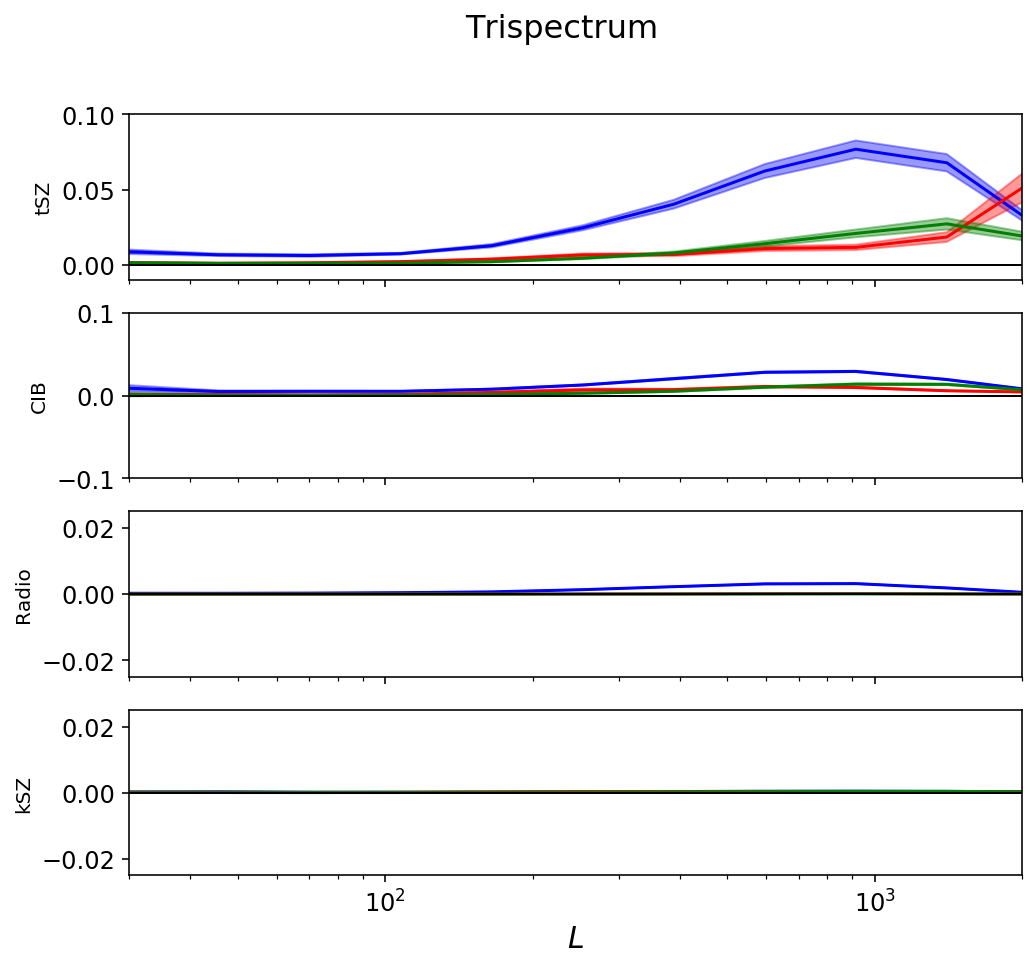

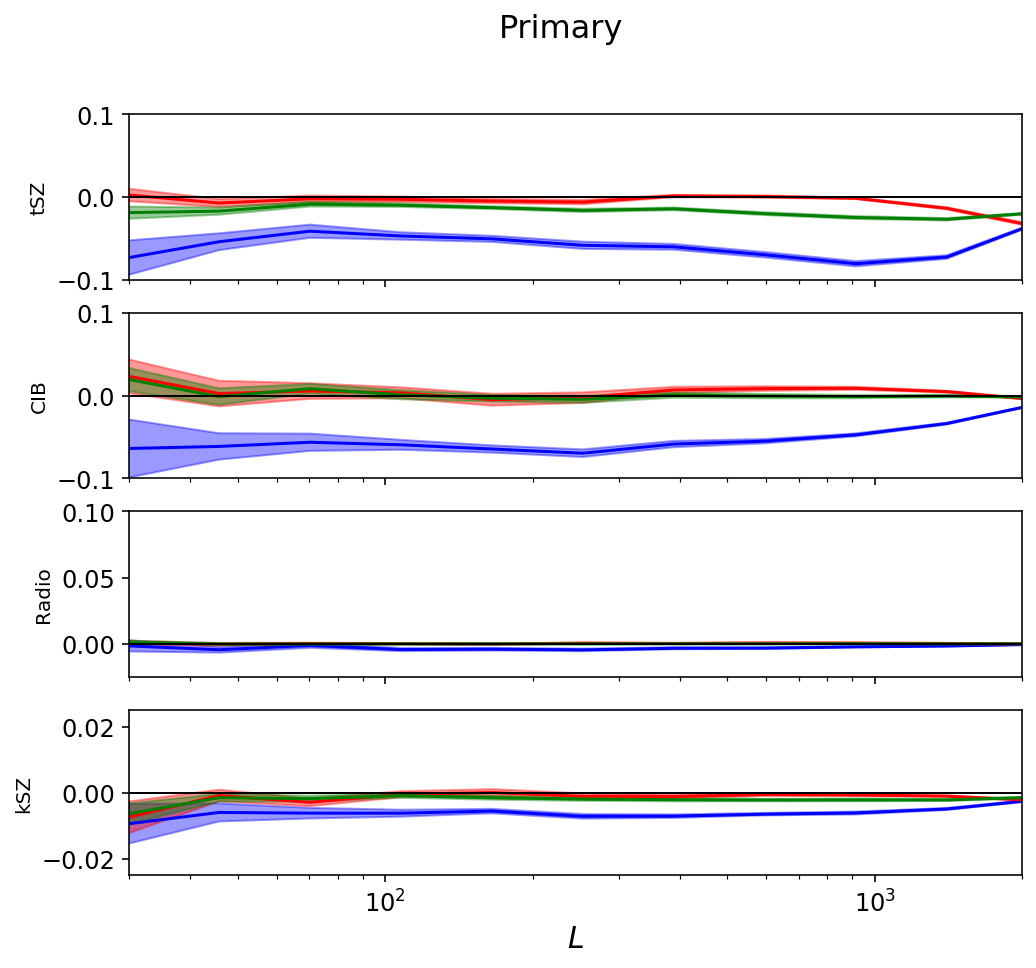

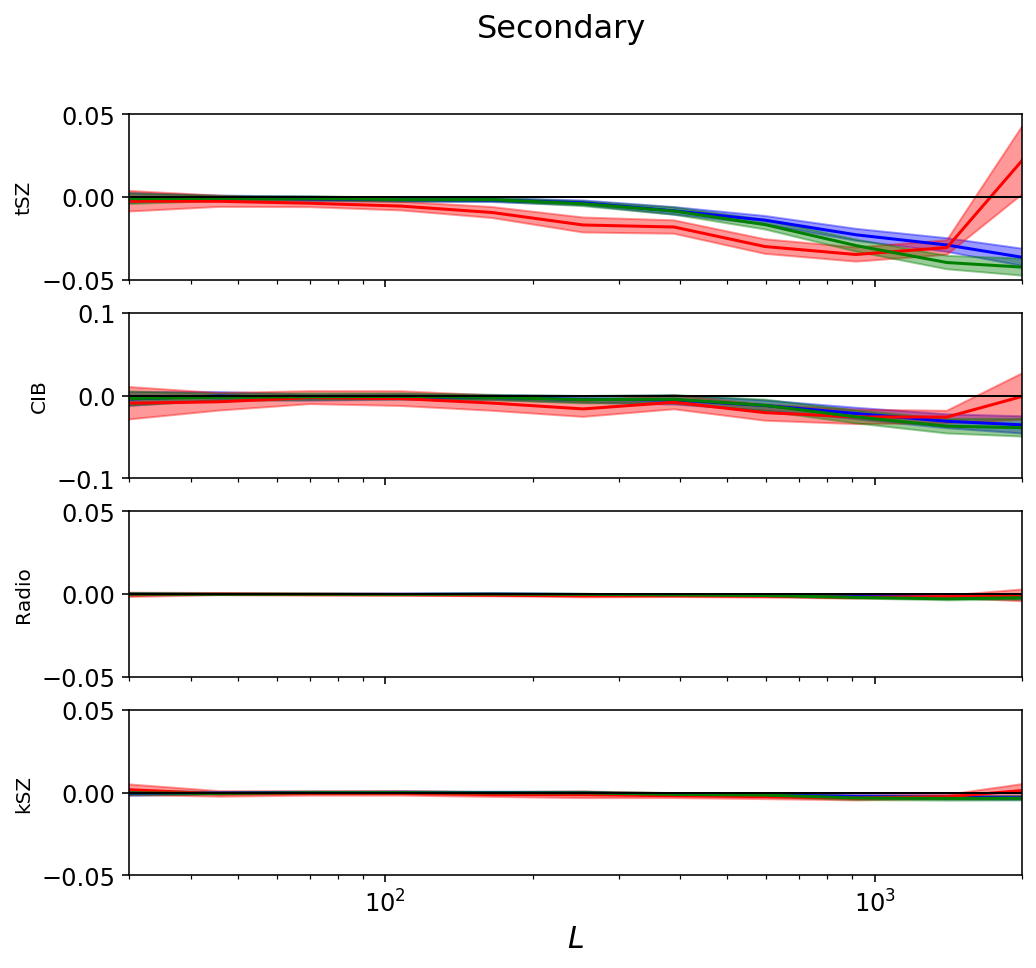

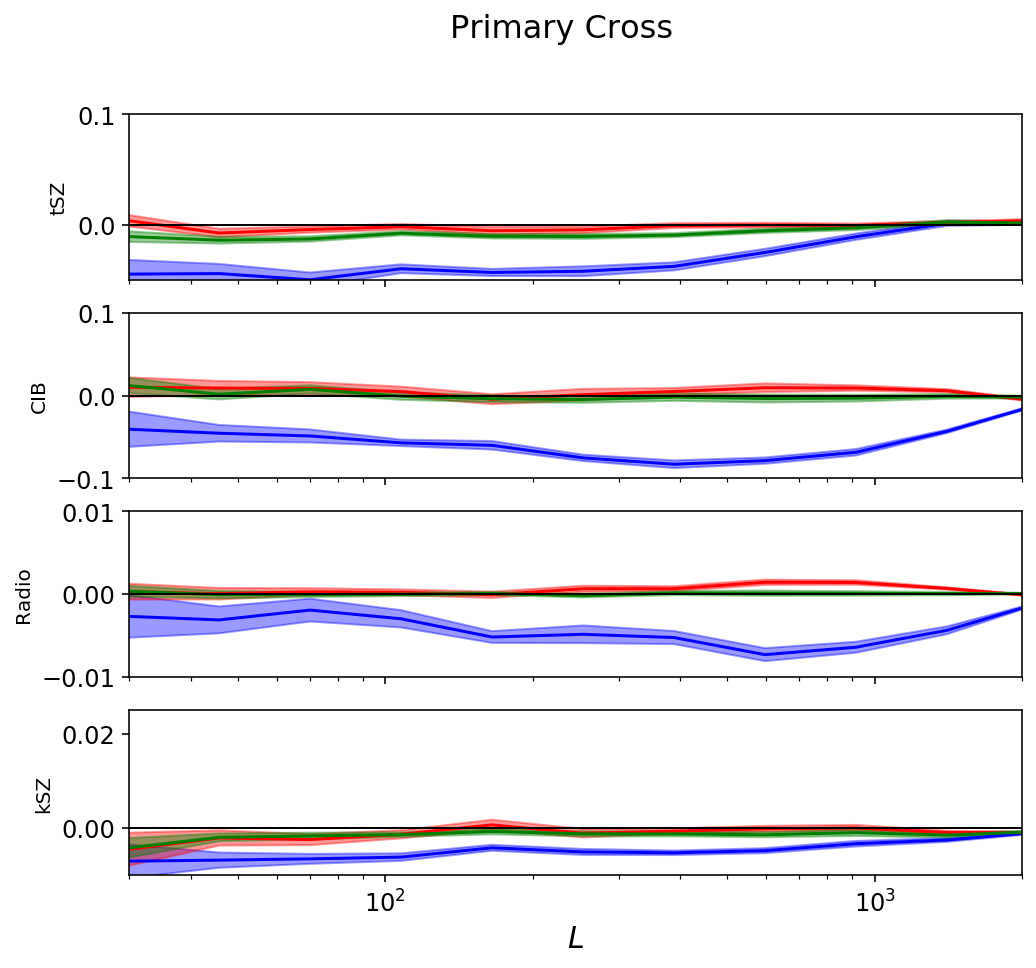

In [199]:
for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
    lmaxes_dict = {}
    lmax_directory = ''
    for e_index, e in enumerate(estimators):
        l = lmaxes[e_index]
        lmaxes_dict[e] = l
        lmax_directory += f'{names[e]}{l}'

    for t in titles:
        fig, ax = plt.subplots(nrows = len(fgnamefiles), ncols = 1, sharex = True, figsize = (8, 7))

        fig.suptitle(f'{t}', fontsize = 16, **csfont)

        #primary = get(primarytag)
        #secondary = get(secondarytag)
        #trispectrum = get(trispectrumtag)

        #primaryscatter = getscatter(primarytag)
        #secondaryscatter = getscatter(secondarytag)
        #trispectrumscatter = getscatter(trispectrumtag)

        for fgindex, fgnamefile in enumerate(fgnamefiles):
            
            P = PP/lmax_directory
            Pfg = PP/lmax_directory/fgnamefile

            getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
            get = lambda key: np.load(Pfg/getoutname(key))

            getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
            getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

            noises = get(noisetag)
            ells = get('ells')
            kk = get('kk')
            kg = get('kg')
            gg = get('gg')
        
            specificbias = get(titles_tags[t])
            specificscatter = getscatter(titles_tags[t])

            ylim = ylims[t]
            
            for e_index, e in enumerate(estimators):
                                
                if specificscatter.ndim > 2:
                    err = specificscatter[e_index, e_index]/kk
                    y = specificbias[e_index, e_index]/kk
                else:
                    err = specificscatter[e_index]/kg
                    y = specificbias[e_index]/kg
                

                ax[fgindex].plot(ells, y, color = colors_ests[e], label = labels_ests[e])
                ax[fgindex].fill_between(ells, y-err, y+err, color = colors_ests[e], alpha = 0.4)

                ax[fgindex].set_ylim(ymin = ylim[fgnamefile]['ymin'], ymax = ylim[fgnamefile]['ymax'])
                ax[fgindex].set_ylabel(f'{foreground[fgnamefile]}')
                ax[fgindex].set_ylim(ylim[fgnamefile]['ymin'], ylim[fgnamefile]['ymax'])
                ax[fgindex].set_xlim(30, 2000)
                ax[fgindex].axhline(y = 0, color = 'black', lw = 1)
                ax[fgindex].tick_params(axis = 'both', which = 'major', labelsize = 12)

        ax[-1].set_xscale('log')
        ax[-1].set_xlabel('$L$', size = 15)

        #fig.savefig(paperplots/'biases_3500.png', dpi = 300)

        plt.show()

In [185]:
dictionary = u.dictionary(savingdirectory, 'h3500s3500b3500')

In [190]:
Nsims = 80
fgnamefile = 'tsz'

total = 0.
totalmanu = 0.

for j in range(Nsims):
    dic = dictionary.read(f'{fgnamefile}_{nu}_{j}')
    total += dic['PC']['PC-hu_ok']
    
    
    
total /= Nsims

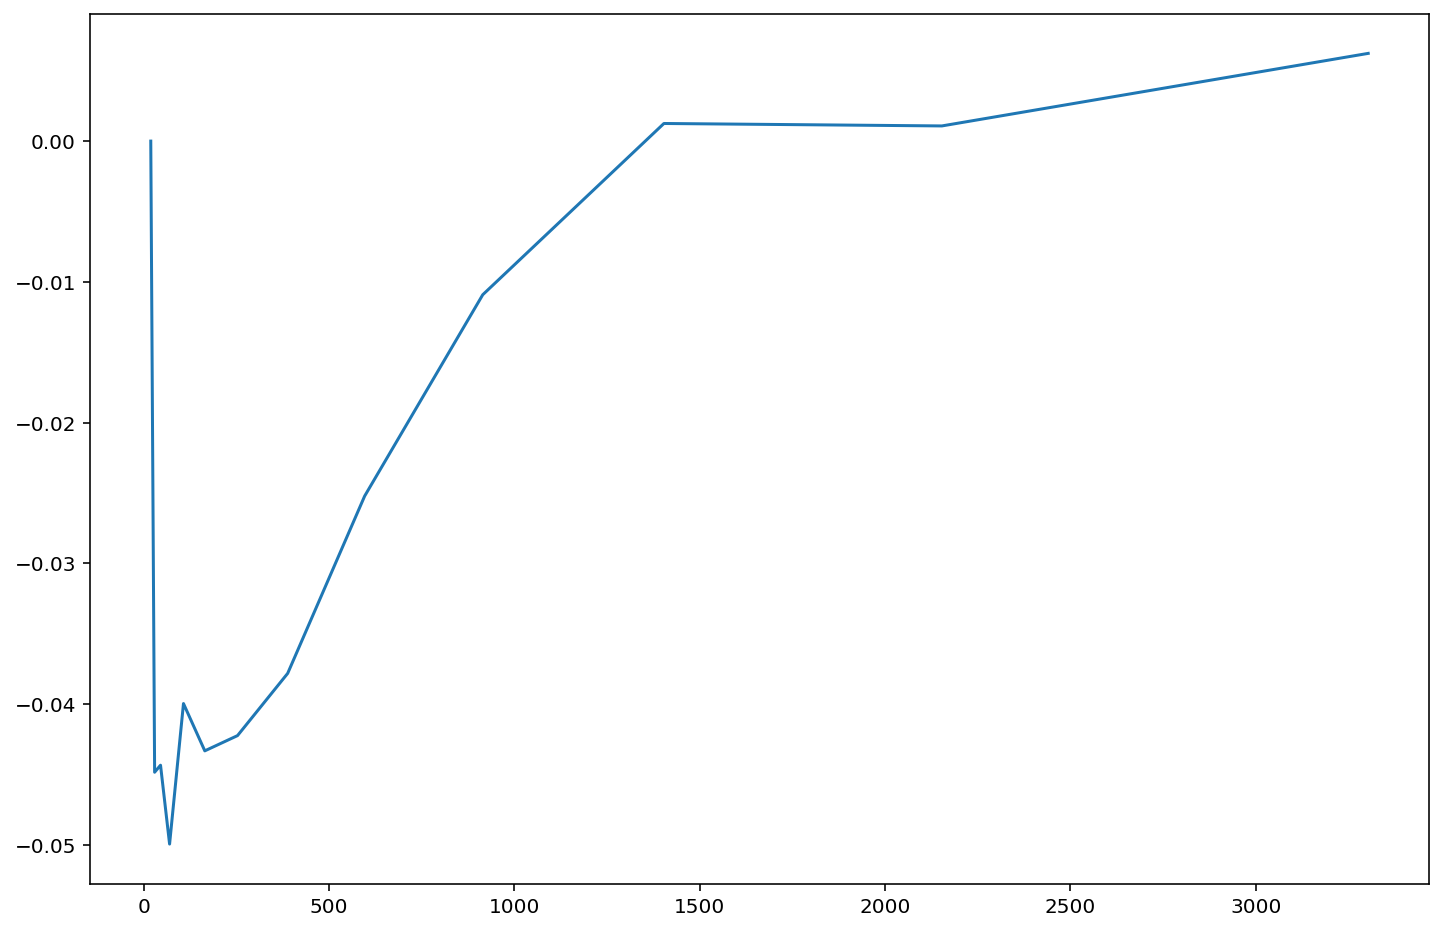

In [193]:
plt.plot(ells, total/kg)

In [159]:
Pfg = PP/lmax_directory/'tsz'

getoutname = lambda key: f'{key}_tsz_{nu}.npy'
get = lambda key: np.load(Pfg/getoutname(key))

b = get(primarycrosstag)

In [163]:
b.shape

(3, 14)